In [ ]:
import tensorflow as tf
print(tf.__version__)

2.4.0


# Model subclassing and custom training loops

 ## Coding tutorials
 #### [1. Model subclassing](#coding_tutorial_1)
 #### [2. Custom layers](#coding_tutorial_2)
 #### [3. Automatic differentiation](#coding_tutorial_3)
 #### [4. Custom training loops](#coding_tutorial_4)
 #### [5. tf.function decorator](#coding_tutorial_5)

***
<a id="coding_tutorial_1"></a>
## Model subclassing

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Softmax, concatenate

#### Create a simple model using the model subclassing API

In [ ]:
# Build the model
class MyModel(Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.dense_1 = Dense(64, activation='relu')
    self.dense_2 = Dense(10)
    self.dropout = Dropout(0.4)
  
  #The keyword argument 'training' allows us to specify different behaviors between training and test time
  def call(self, inputs, training=True):
    h = self.dense_1(inputs)
    if training:
      h = self.dropout(h)
    outputs = self.dense_2(h)
    return outputs


In [ ]:
# Print the model summary
model=  MyModel()

#Call the model on some random inputs to initialize the weights
model(tf.random.uniform([1,10]))

print(model.summary())



Model: "my_model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              multiple                  704       
_________________________________________________________________
dense_5 (Dense)              multiple                  650       
_________________________________________________________________
dropout_2 (Dropout)          multiple                  0         
Total params: 1,354
Trainable params: 1,354
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# Now create a model that can concatenate the output of 2 layers
class MyModel(Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.dense_1 = Dense(64, activation='relu')
    self.dense_2 = Dense(10)
    self.dense_3 = Dense(5)
    self.softmax = Softmax()

  def call(self, inputs, training=True):
    x1 = self.dense_1(inputs)
    x2 = self.dense_2(inputs)
    x3 = self.dense_3(x2)
    concat = concatenate([x1, x3])

    outputs = self.softmax(concat)
    return outputs

In [ ]:
# Print the model summary
model=  MyModel()

#Call the model on some random inputs to initialize the weights
model(tf.random.uniform([1,10]))

print(model.summary())


Model: "my_model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              multiple                  704       
_________________________________________________________________
dense_10 (Dense)             multiple                  110       
_________________________________________________________________
dense_11 (Dense)             multiple                  55        
_________________________________________________________________
softmax_1 (Softmax)          multiple                  0         
Total params: 869
Trainable params: 869
Non-trainable params: 0
_________________________________________________________________
None


***
<a id="coding_tutorial_2"></a>
## Custom layers

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax

#### Create custom layers

In [ ]:
# Create a custom layer
class MyLayer(Layer):
  def __init__(self, units, input_dim):
    super(MyLayer, self).__init__()
    self.w = self.add_weight(shape=(input_dim, units), initializer='random_normal')
    self.b = self.add_weight(shape=(units,), initializer='zeros')

  def call(self, inputs):
    return tf.matmul(inputs, self.w) + self.b


dense_layer = MyLayer(3, 5)
x = tf.ones((1,5))
print(dense_layer(x))
print(dense_layer.weights)


tf.Tensor([[ 0.09514741 -0.11155566 -0.05011199]], shape=(1, 3), dtype=float32)
[<tf.Variable 'Variable:0' shape=(5, 3) dtype=float32, numpy=
array([[ 0.04255335, -0.01449257,  0.01525424],
       [ 0.01394487, -0.05390855, -0.03989207],
       [ 0.02004004,  0.00697046, -0.02588107],
       [ 0.01674328, -0.02561227,  0.02205108],
       [ 0.00186587, -0.02451273, -0.02164416]], dtype=float32)>, <tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>]


In [ ]:
# Specify trainable weights
class MyLayer(Layer):
  def __init__(self, units, input_dim):
    super(MyLayer, self).__init__()
    self.w = self.add_weight(shape=(input_dim, units), initializer='random_normal', trainable=False)
    self.b = self.add_weight(shape=(units,), initializer='zeros', trainable=False)

  def call(self, inputs):
    return tf.matmul(inputs, self.w) + self.b


dense_layer = MyLayer(3, 5)



In [ ]:
print('trainable weights:', len(dense_layer.trainable_weights))
print('non-trainable weights:', len(dense_layer.non_trainable_weights))

trainable weights: 0
non-trainable weights: 2


In [ ]:
# Create a custom layer to accumulate means of output values
class MyLayerMean(Layer):
  def __init__(self, units, input_dim):
    super(MyLayerMean, self).__init__()
    self.w = self.add_weight(shape=(input_dim, units), initializer='random_normal')
    self.b = self.add_weight(shape=(units,), initializer='zeros')
    self.sum_activation = tf.Variable(initial_value=tf.zeros((units,)), trainable=False)
    self.number_calls = tf.Variable(initial_value=0, trainable=False)

  def call(self, inputs):
    activations = tf.matmul(inputs, self.w) + self.b
    self.sum_activation.assign_add(tf.reduce_sum(activations,axis=0))
    self.number_calls.assign_add(inputs.shape[0])
    return activations, self.sum_activation / tf.cast(self.number_calls, tf.float32)

dense_layer = MyLayerMean(3,5)

In [ ]:
# Test the layer

y, activation_means = dense_layer(tf.ones((1, 5)))
print(activation_means.numpy())

[-0.00269412 -0.1146684  -0.19908628]


In [ ]:
# Create a Dropout layer as a custom layer

class MyDropout(Layer):

    def __init__(self, rate):
        super(MyDropout, self).__init__()
        self.rate = rate
        
    def call(self, inputs):
        # Define forward pass for dropout layer
        return tf.nn.dropout(inputs, self.rate)

#### Implement the custom layers into a model

In [ ]:
# Build the model using custom layers with the model subclassing API

class MyModel(Model):

    def __init__(self, units_1, input_dim_1, units_2, units_3):
        super(MyModel, self).__init__()
        # Define layers
        self.layer_1 = MyLayer(units_1, input_dim_1)
        self.dropout_1 = MyDropout(0.5)
        self.layer_2 = MyLayer(units_2, units_1)
        self.dropout_2 = MyDropout(0.5)
        self.layer_3 = MyLayer(units_3, units_2)
        self.softmax = Softmax()
           
    def call(self, inputs):
        # Define forward pass
        x = self.layer_1(inputs)
        x = tf.nn.relu(x)
        x = self.dropout_1(x)
        x = self.layer_2(x)
        x = tf.nn.relu(x)
        x = self.dropout_2(x)
        x = self.layer_3(x)
        x = self.softmax(x)
        return x

In [ ]:
# Instantiate a model object

model = MyModel(64,10000,64,46)
print(model(tf.ones((1, 10000))))
model.summary()

tf.Tensor(
[[0.02633101 0.00198361 0.00222045 0.00620659 0.00256756 0.09324398
  0.03123465 0.0424901  0.0335867  0.00647521 0.02234882 0.10264975
  0.03690673 0.01182272 0.0205191  0.01468953 0.00858904 0.02103092
  0.01092772 0.02422823 0.00504971 0.00318879 0.06010472 0.04771877
  0.02669424 0.02196812 0.00203028 0.00413198 0.03220353 0.00610708
  0.01764489 0.00576759 0.02231438 0.02059561 0.01720363 0.0034402
  0.00549448 0.01247614 0.00952379 0.00645586 0.04304749 0.00178598
  0.00637557 0.04489164 0.0451513  0.00858182]], shape=(1, 46), dtype=float32)
Model: "my_model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_layer_5 (MyLayer)         multiple                  640064    
_________________________________________________________________
my_dropout (MyDropout)       multiple                  0         
_________________________________________________________________
my_layer_6 (MyLayer

***
<a id="coding_tutorial_3"></a>
## Automatic differentiation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#### Create synthetic data

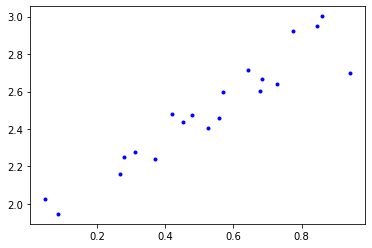

In [ ]:
# Create data from a noise contaminated linear model

def MakeNoisyData(m, b, n=20):
    x = tf.random.uniform(shape=(n,))
    noise = tf.random.normal(shape=(len(x),), stddev=0.1)
    y = m * x + b + noise
    return x, y

m=1
b=2
x_train, y_train = MakeNoisyData(m,b)
plt.plot(x_train, y_train, 'b.')

#### Define a linear regression model

In [ ]:
from tensorflow.keras.layers import Layer

In [ ]:
# Build a custom layer for the linear regression model
class LinearLayer(Layer):
  def __init__(self):
    super(LinearLayer, self).__init__()
    self.m = self.add_weight(shape=(1,), initializer='random_normal')
    self.b = self.add_weight(shape=(1,), initializer='zeros')

  def call(self, inputs):
    return self.m * inputs + self.b

linear_regression = LinearLayer()
print(linear_regression(x_train))
print(linear_regression.weights)

tf.Tensor(
[0.00714936 0.01085589 0.0107654  0.01364011 0.00076742 0.00586212
 0.00440506 0.00423265 0.01018025 0.00135957 0.00901689 0.00760256
 0.01154659 0.00883382 0.01339642 0.01228215 0.00493549 0.0083111
 0.01493166 0.00666109], shape=(20,), dtype=float32)
[<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.01586097], dtype=float32)>, <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]


#### Define the loss function

In [ ]:
# Define the mean squared error loss function

def SquaredError(y_pred, y_true):
    return tf.reduce_mean(tf.square(y_pred - y_true)) 

starting_loss = SquaredError(linear_regression(x_train), y_train)
print("Starting loss", starting_loss.numpy())

Starting loss 6.278594


#### Train and plot the model

In [ ]:
# Implement a gradient descent training loop for the linear regression model
learning_rate = 0.05
steps = 25

for i in range(25):
  with tf.GradientTape() as tape:
    predictions = linear_regression(x_train)
    loss = SquaredError(predictions, y_train)

  gradients = tape.gradient(loss, linear_regression.trainable_variables)

  linear_regression.m.assign_sub(learning_rate * gradients[0])
  linear_regression.b.assign_sub(learning_rate * gradients[1])
  print(f"Step: {i}, loss: {loss.numpy()} ")


Step: 0, loss: 4.765766143798828 
Step: 1, loss: 3.617985963821411 
Step: 2, loss: 2.7471675872802734 
Step: 3, loss: 2.0864789485931396 
Step: 4, loss: 1.5852159261703491 
Step: 5, loss: 1.2049086093902588 
Step: 6, loss: 0.9163699150085449 
Step: 7, loss: 0.6974561214447021 
Step: 8, loss: 0.5313665866851807 
Step: 9, loss: 0.40535467863082886 
Step: 10, loss: 0.3097495436668396 
Step: 11, loss: 0.23721417784690857 
Step: 12, loss: 0.18218152225017548 
Step: 13, loss: 0.14042845368385315 
Step: 14, loss: 0.10875032842159271 
Step: 15, loss: 0.08471616357564926 
Step: 16, loss: 0.06648143380880356 
Step: 17, loss: 0.052646704018116 
Step: 18, loss: 0.04215029627084732 
Step: 19, loss: 0.03418663144111633 
Step: 20, loss: 0.028144564479589462 
Step: 21, loss: 0.02356041595339775 
Step: 22, loss: 0.020082363858819008 
Step: 23, loss: 0.017443524673581123 
Step: 24, loss: 0.015441400930285454 


m:1,  trained m:[1.0531754]
b:2,  trained b:[1.8763323]


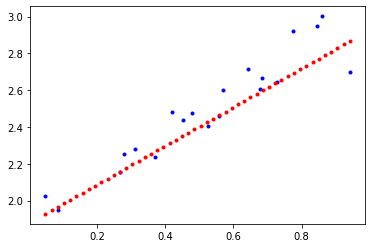

In [ ]:
# Plot the learned regression model

print("m:{},  trained m:{}".format(m,linear_regression.m.numpy()))
print("b:{},  trained b:{}".format(b,linear_regression.b.numpy()))

plt.plot(x_train, y_train, 'b.')

x_linear_regression=np.linspace(min(x_train), max(x_train),50)
plt.plot(x_linear_regression, linear_regression.m*x_linear_regression+linear_regression.b, 'r.')

***
<a id="coding_tutorial_4"></a>
## Custom training loops

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

#### Build the model

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax

In [ ]:
# Define the custom layers and model
class MyLayer(Layer):
  def __init__(self, units):
    super(MyLayer, self).__init__()
    self.units = units

  def build(self, input_shape):
    self.w = self.add_weight(shape=(input_shape[-1], self.units), initializer='random_normal', name='kernel')
    self.b = self.add_weight(shape=(self.units,), initializer='zeros', name='bias')

  def call(self, inputs):
    return tf.matmul(inputs, self.w) + self.b

class MyDropout(Layer):

    def __init__(self, rate):
        super(MyDropout, self).__init__()
        self.rate = rate
        
    def call(self, inputs):
        # Define forward pass for dropout layer
        return tf.nn.dropout(inputs, self.rate)


class MyModel(Model):

    def __init__(self, units_1, units_2, units_3):
        super(MyModel, self).__init__()
        # Define layers
        self.layer_1 = MyLayer(units_1)
        self.dropout_1 = MyDropout(0.5)
        self.layer_2 = MyLayer(units_2)
        self.dropout_2 = MyDropout(0.5)
        self.layer_3 = MyLayer(units_3)
        self.softmax = Softmax()
           
    def call(self, inputs):
        # Define forward pass
        x = self.layer_1(inputs)
        x = tf.nn.relu(x)
        x = self.dropout_1(x)
        x = self.layer_2(x)
        x = tf.nn.relu(x)
        x = self.dropout_2(x)
        x = self.layer_3(x)
        x = self.softmax(x)
        return x

In [ ]:
model = MyModel(64,64,46)
print(model(tf.ones((1, 10000))))
print(model.summary())

tf.Tensor(
[[0.01196322 0.01685798 0.06014134 0.02053736 0.01291707 0.02397374
  0.01238401 0.03083515 0.0170014  0.01703889 0.01282162 0.01141806
  0.00517085 0.0099032  0.02382981 0.01002738 0.0030489  0.02816356
  0.02539356 0.01885603 0.00510387 0.01870598 0.06972812 0.01580283
  0.00946773 0.02818713 0.01493033 0.04669761 0.0125139  0.01898383
  0.01734614 0.01781262 0.02562639 0.02294711 0.00947327 0.07340343
  0.04024573 0.01414134 0.00563371 0.02215508 0.00952637 0.03157276
  0.01172916 0.01421362 0.0159739  0.05579495]], shape=(1, 46), dtype=float32)
Model: "my_model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_layer_11 (MyLayer)        multiple                  640064    
_________________________________________________________________
my_dropout_8 (MyDropout)     multiple                  0         
_________________________________________________________________
my_layer_12 (MyLay

#### Load the reuters dataset and define the class_names 

In [ ]:
# Load the dataset

from tensorflow.keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

class_names = ['cocoa','grain','veg-oil','earn','acq','wheat','copper','housing','money-supply',
   'coffee','sugar','trade','reserves','ship','cotton','carcass','crude','nat-gas',
   'cpi','money-fx','interest','gnp','meal-feed','alum','oilseed','gold','tin',
   'strategic-metal','livestock','retail','ipi','iron-steel','rubber','heat','jobs',
   'lei','bop','zinc','orange','pet-chem','dlr','gas','silver','wpi','hog','lead']

2113536/2110848 [==============================] - 0s 0us/step


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [ ]:
# Print the class of the first sample

print("Label: {}".format(class_names[train_labels[0]]))

Label: earn


#### Get the dataset word index

In [ ]:
# Load the Reuters word index

word_to_index = reuters.get_word_index()

invert_word_index = dict([(value, key) for (key, value) in word_to_index.items()])
text_news = ' '.join([invert_word_index.get(i - 3, '?') for i in train_data[0]])

557056/550378 [==============================] - 0s 0us/step


In [ ]:
# Print the first data example sentence
print(text_news)


? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


#### Preprocess the data

In [ ]:
# Define a function that encodes the data into a 'bag of words' representation

def bag_of_words(text_samples, elements=10000):
    output = np.zeros((len(text_samples), elements))
    for i, word in enumerate(text_samples):
        output[i, word] = 1.
    return output

x_train = bag_of_words(train_data)
x_test = bag_of_words(test_data)

print("Shape of x_train:", x_train.shape)
print("Shape of x_test:", x_test.shape)

Shape of x_train: (8982, 10000)
Shape of x_test: (2246, 10000)


#### Define the loss function and optimizer



In [ ]:
# Define the categorical cross entropy loss and Adam optimizer

loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

def loss(model, x, y, wd):
    kernel_variables = []
    for l in model.layers:
        for w in l.weights:
            if 'kernel' in w.name:
                kernel_variables.append(w)
    wd_penalty = wd * tf.reduce_sum([tf.reduce_sum(tf.square(k)) for k in kernel_variables])
    y_ = model(x)
    return loss_object(y_true=y, y_pred=y_) + wd_penalty

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

#### Train the model

In [ ]:
# Define a function to compute the forward and backward pass

def grad(model, inputs, targets, wd):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, wd)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [ ]:
print(x_train.shape)
print(train_labels.shape)

(8982, 10000)
(8982,)


In [ ]:
# Implement the training loop

from tensorflow.keras.utils import to_categorical

start_time = time.time()

train_dataset = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
train_dataset = train_dataset.batch(32, drop_remainder=True)

#Keep results for plotting

train_loss_results = []
train_accuracy_results = []

n_epochs = 10
weight_decay = 0.005

for epoch in range(n_epochs):
  epoch_loss_avg = tf.keras.metrics.Mean()
  epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

  #Training loop
  for x,y in train_dataset:
    #Optimizer model
    loss_value, grads, = grad(model, x, y, weight_decay)
    optimizer.apply_gradients(zip(grads,model.trainable_variables))

    #Compute current loss average across the batch
    epoch_loss_avg(loss_value)
    #Compute the accuracy across the batch
    epoch_accuracy(to_categorical(y), model(x))
  
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())

  print(f"Epoch: {epoch}, Loss: {epoch_loss_avg.result()}, Accuracy: {epoch_accuracy.result()}")


    
    
print("Duration :{:.3f}".format(time.time() - start_time))

Epoch: 0, Loss: 3.3155524730682373, Accuracy: 0.4898437559604645
Epoch: 1, Loss: 1.9206002950668335, Accuracy: 0.6073660850524902
Epoch: 2, Loss: 1.8132153749465942, Accuracy: 0.6674107313156128
Epoch: 3, Loss: 1.7752587795257568, Accuracy: 0.6939732432365417
Epoch: 4, Loss: 1.7421848773956299, Accuracy: 0.6939732432365417
Epoch: 5, Loss: 1.7222602367401123, Accuracy: 0.6975446343421936
Epoch: 6, Loss: 1.7193176746368408, Accuracy: 0.7014508843421936
Epoch: 7, Loss: 1.7013343572616577, Accuracy: 0.7090401649475098
Epoch: 8, Loss: 1.7067021131515503, Accuracy: 0.7071428298950195
Epoch: 9, Loss: 1.6987274885177612, Accuracy: 0.7099330425262451
Duration :44.503


#### Evaluate the model

In [ ]:
# Create a Dataset object for the test set

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, test_labels))
test_dataset = test_dataset.batch(32)

In [ ]:
# Collect average loss and accuracy

epoch_loss_avg = tf.keras.metrics.Mean()
epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

In [ ]:
# Loop over the test set and print scores

from tensorflow.keras.utils import to_categorical

for x, y in test_dataset:
    # Optimize the model
    loss_value = loss(model, x, y, weight_decay)    
    # Compute current loss
    epoch_loss_avg(loss_value)  
    # Compare predicted label to actual label
    epoch_accuracy(to_categorical(y), model(x))

print("Test loss: {:.3f}".format(epoch_loss_avg.result().numpy()))
print("Test accuracy: {:.3%}".format(epoch_accuracy.result().numpy()))

Test loss: 1.829
Test accuracy: 67.676%


#### Plot the learning curves

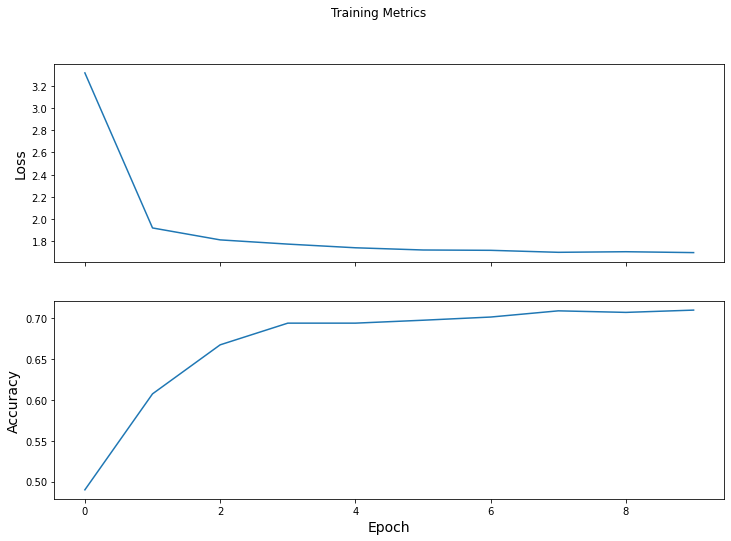

In [ ]:
# Plot the training loss and accuracy

fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

#### Predict from the model

In [ ]:
# Get the model prediction for an example input

predicted_label = np.argmax(model(x_train[np.newaxis,0]),axis=1)[0]
print("Prediction: {}".format(class_names[predicted_label]))
print("     Label: {}".format(class_names[train_labels[0]]))

Prediction: earn
     Label: earn


***
<a id="coding_tutorial_5"></a>
## tf.function decorator

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import reuters
import numpy as np
import matplotlib.pyplot as plt
import time

#### Build the model

In [ ]:
# Initialize a new model
model = MyModel(64,64,46)



#### Redefine the grad function using the @tf.function decorator

In [ ]:
# Use the @tf.function decorator
@tf.function
def grad(model, inputs, targets, wd):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, wd)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)


#### Train the model

In [ ]:
# Re-run the training loop

from tensorflow.keras.utils import to_categorical

start_time = time.time()

train_dataset = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
train_dataset = train_dataset.batch(32, drop_remainder=True)

#Keep results for plotting

train_loss_results = []
train_accuracy_results = []

n_epochs = 10
weight_decay = 0.005

for epoch in range(n_epochs):
  epoch_loss_avg = tf.keras.metrics.Mean()
  epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

  #Training loop
  for x,y in train_dataset:
    #Optimizer model
    loss_value, grads, = grad(model, x, y, weight_decay)
    optimizer.apply_gradients(zip(grads,model.trainable_variables))

    #Compute current loss average across the batch
    epoch_loss_avg(loss_value)
    #Compute the accuracy across the batch
    epoch_accuracy(to_categorical(y), model(x))
  
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())

  print(f"Epoch: {epoch}, Loss: {epoch_loss_avg.result()}, Accuracy: {epoch_accuracy.result()}")


    
    
print("Duration :{:.3f}".format(time.time() - start_time))


Epoch: 0, Loss: 3.31367826461792, Accuracy: 0.49241071939468384
Epoch: 1, Loss: 1.8863627910614014, Accuracy: 0.6183035969734192
Epoch: 2, Loss: 1.8123087882995605, Accuracy: 0.6489955186843872
Epoch: 3, Loss: 1.7823914289474487, Accuracy: 0.6705357432365417
Epoch: 4, Loss: 1.7581056356430054, Accuracy: 0.6847098469734192
Epoch: 5, Loss: 1.7367846965789795, Accuracy: 0.6924107074737549
Epoch: 6, Loss: 1.7309012413024902, Accuracy: 0.6964285969734192
Epoch: 7, Loss: 1.7141116857528687, Accuracy: 0.7026785612106323
Epoch: 8, Loss: 1.7182064056396484, Accuracy: 0.703906238079071
Epoch: 9, Loss: 1.6956614255905151, Accuracy: 0.7079241275787354
Duration :33.318


#### Print the autograph code

In [ ]:
# Use tf.autograph.to_code to see the generated code
print(tf.autograph.to_code(grad.python_function))


def tf__grad(model, inputs, targets, wd):
    with ag__.FunctionScope('grad', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
        do_return = False
        retval_ = ag__.UndefinedReturnValue()
        with ag__.ld(tf).GradientTape() as tape:
            loss_value = ag__.converted_call(ag__.ld(loss), (ag__.ld(model), ag__.ld(inputs), ag__.ld(targets), ag__.ld(wd)), None, fscope)
        try:
            do_return = True
            retval_ = (ag__.ld(loss_value), ag__.converted_call(ag__.ld(tape).gradient, (ag__.ld(loss_value), ag__.ld(model).trainable_variables), None, fscope))
        except:
            do_return = False
            raise
        return fscope.ret(retval_, do_return)

